In [2]:
import os
import json
import numpy as np
import nibabel as nib
import pandas as pd

from glob import glob

In [3]:
'''
project_dir = os.path.join('/Users/KRS228/',
                         'OneDrive - University of Pittsburgh/7T',)
model_dir = os.path.join(project_dir,
                         'task-stgrid')
sub_list = [os.path.basename(x).split('_')[0] for x in sorted(glob(os.path.abspath(model_dir) + '/*'))]
'''

### CRC data loading

In [3]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

bidsroot = os.path.join(project_dir, 'archive', 'data_bids_noIntendedFor')
deriv_dir = os.path.join(bidsroot, 'derivatives')

nilearn_dir = os.path.join(deriv_dir, 'nilearn')
print(nilearn_dir)

task_list = ['tonecat']


/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/derivatives/nilearn


In [4]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT01',
               #'sub-FLT16',
               #'sub-FLT19', 'sub-FLT20', 
               #'sub-FLT25', 'sub-FLT26', 
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/participants.tsv'

In [ ]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

sub_list_prepend = sub_list_mand + sub_list_nman

For `desc-carpet_dseg`, see TemplateFlow: https://raw.githubusercontent.com/templateflow/tpl-MNI152NLin2009cAsym/master/tpl-MNI152NLin2009cAsym_desc-carpet_dseg.tsv

## define masks and function

In [4]:
roi_dict_MNI_dseg = {'L-Caud': 35, 'L-Put': 36, 'L-HG': 189, 'L-PP': 187, 'L-PT': 191, 'L-STGa': 117, 'L-STGp': 119, 'L-ParsOp': 111, 'L-ParsTri': 109, 
                     'R-Caud': 46, 'R-Put': 47, 'R-HG': 190, 'R-PP': 188, 'R-PT': 192, 'R-STGa': 118, 'R-STGp': 120, 'R-ParsOp': 112, 'R-ParsTri': 110, }

In [5]:
roi_dict_T1w_aseg = {'L-VentralDC': 28, 'L-Caud': 11, 'L-Put': 12, 'L-HG': 1034, 'L-STG': 1030, 'L-ParsOp': 1018, 'L-ParsTri': 1020, 'L-SFG': 1028, 'Brainstem': 16, 
                     'R-VentralDC': 60, 'R-Caud': 50, 'R-Put': 51, 'R-HG': 2034, 'R-STG': 2030, 'R-ParsOp': 2018, 'R-ParsTri': 2020, 'R-SFG': 2028, 'CSF': 24}

In [6]:
roi_dict_MNI_sg_subcort = {'L-CN': 1, 'L-SOC': 3, 'L-IC': 5, 'L-MGN': 7, 
                           'R-CN': 2, 'R-SOC': 4, 'R-IC': 6, 'R-MGN': 8, }

In [7]:
def mask_fmri(fmri_niimgs, mask_filename, fwhm):
    from nilearn.maskers import NiftiMasker
    masker = NiftiMasker(mask_img=mask_filename, #runs=session_label,
                         smoothing_fwhm=fwhm, standardize=True,
                         memory="nilearn_cache", memory_level=1)
    fmri_masked = masker.fit_transform(fmri_niimgs)
    return fmri_masked, masker

## generate anatomical masks

In [ ]:
def generate_mask(sub_id, zmap_example_fpath, atlas_fpath, labelnum, labelname, out_dir, spacelabel):
    from nilearn.image import resample_to_img
    
    atlas_img = nib.load(atlas_fpath)
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    
    mask_data = np.zeros((atlas_data.shape))
    mask_data[np.where(atlas_data == labelnum)] = 1

    mask_img = nib.Nifti1Image(mask_data, atlas_affine)

    mask_func_img = resample_to_img(mask_img, zmap_example_fpath, interpolation='nearest')
    
    out_fpath = os.path.join(out_dir, '%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, labelname))
    nib.save(mask_func_img, out_fpath)
    
    return out_fpath

In [ ]:
'''
fwhm_sub = 0
space_label = 'MNI152NLin2009cAsym' # 'T1w' # 'MNI152NLin2009cAsym' #
atlas_label =  'subcort_aud' # 'subcort_aud' 'carpet_dseg' # 'aparc'

for mx, sub_id in enumerate(sub_list):
    print(sub_id)
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                               'level-1_fwhm-%.02f'%fwhm_sub, 
                                               '%s_space-%s'%(sub_id, space_label))    
    print(nilearn_sub_dir)
    zmap_example_fpath = z_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*tstat.nii.gz'))[0]
    
    if space_label == 'T1w' and atlas_label == 'aparc': 
        atlas_fpath = os.path.join(fmriprep_dir, sub_id, 'anat',
                                    '%s_desc-%saseg_dseg.nii.gz'%(sub_id, atlas_label))


        sub_mask_dir = os.path.join(nilearn_dir, 'masks', sub_id, 
                                    'space-%s'%space_label, 'masks-aparc') 
        roi_dict = roi_dict_T1w_aseg
    elif space_label == 'MNI152NLin2009cAsym' and atlas_label == 'carpet_dseg': 
        atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                                   'reference/', #tpl-MNI152NLin2009cAsym/',
                                   'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz')  
        sub_mask_dir = os.path.join(nilearn_dir, 'masks', sub_id, 
                                    'space-%s'%space_label, 'masks-dseg')  
        roi_dict = roi_dict_MNI_dseg
    elif space_label == 'MNI152NLin2009cAsym' and atlas_label == 'subcort_aud':
        atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                                   'reference/MNI_space/atlases',
                                   'sub-bigbrain_MNI_conjunction_rois.nii.gz')
        sub_mask_dir = os.path.join(nilearn_dir, 'masks', sub_id, 
                                    'space-%s'%space_label, 'masks-subcort-aud')  
        roi_dict = roi_dict_MNI_sg_subcort
    else:
        print('mismatch between space label and atlas label')
    if not os.path.exists(sub_mask_dir):
        os.makedirs(sub_mask_dir)
                
    for key, value in roi_dict.items():
        print('generating {} mask file'.format(key))
        mask_fpath = generate_mask(sub_id, zmap_example_fpath, atlas_fpath, 
                                   value, key, sub_mask_dir, space_label)
'''

### plot gray matter searchlight

#### first, make gray matter masks

In [56]:
def generate_mask(subject_id, statmap_example_fpath, out_dir, space_label):
    from nilearn.image import resample_to_img
    
    # read in the overall brain mask
    anat_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                            'derivatives/fmriprep_noSDC/sub-{}/anat'.format(subject_id))

    # create binarized gray matter mask
    gm_fpath = os.path.join(anat_dir, 'sub-{}_space-{}_label-GM_probseg.nii.gz'.format(subject_id, space_label))
    gm_img = nib.load(gm_fpath)
    
    from nilearn.image import binarize_img
    gm_bin_img = binarize_img(gm_img, threshold=0.9)
    
    '''
    atlas_img = nib.load(atlas_fpath)
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    
    mask_data = np.zeros((atlas_data.shape))
    mask_data[np.where(atlas_data == labelnum)] = 1

    mask_img = nib.Nifti1Image(mask_data, atlas_affine)
    '''

    mask_func_img = resample_to_img(gm_bin_img, statmap_example_fpath, interpolation='nearest')
    
    labelname = 'gm-thr90'
    out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(subject_id, space_label, labelname))
    nib.save(mask_func_img, out_fpath)
    
    return out_fpath

## Extract voxels from an ROI

In [9]:
#roi_list = list(roi_dict_MNI_dseg.keys()) # roi_dict_MNI_sg_subcort

roi_list = ['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'L-ParsOp', 'L-ParsTri', 
            'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 'R-ParsOp', 'R-ParsTri', ]

fwhm_sub = 0.
space_label = 'MNI152NLin2009cAsym'
stat_descrip = 'tstat' # 'beta'

print(roi_list)

['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'L-ParsOp', 'L-ParsTri', 'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 'R-ParsOp', 'R-ParsTri']


#### Trial-specific

In [ ]:
for sub_id in sub_list_prepend:
    print(sub_id)

    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   '%s_space-%s'%(sub_id, space_label), 
                                   'trial_models', 
                                  )
    print(nilearn_sub_dir)
    
    out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked',
                           'trial_models')
    os.makedirs(out_dir, exist_ok=True)
    
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        masks_dir = os.path.join(nilearn_dir, 'masks', sub_id, 'space-%s'%space_label, 'masks-dseg')#, 'masks-aparc' 'masks-subcort-aud'
        mask_fpath = os.path.join(masks_dir, '%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        print(sorted(glob(nilearn_sub_dir+'/run*')))
        # run-specific stimulus stat maps
        for rx, run_dir in enumerate(sorted(glob(nilearn_sub_dir+'/run*'))):
            stat_maps = sorted(glob(run_dir+'/*di*map-{}.nii.gz'.format(stat_descrip))) 
            print('# of stat maps: ', len(stat_maps))    

            conditions_all = ['_'.join(os.path.basename(x).split('_')[5:8]) for x in (stat_maps)]

            for sx, stat_fpath in enumerate(stat_maps):
                cond_label = conditions_all[sx]
                #print(cond_label)
                
                #print('masking ', mask_descrip)
                fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

                # save out
                out_fpath = os.path.join(out_dir, '%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, rx, cond_label, stat_descrip))
                np.savetxt(out_fpath, fmri_masked)
                #print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

                masked_out_fpath = os.path.join(out_dir, '%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip,  rx, cond_label, stat_descrip))
                masked_img = masker.inverse_transform(fmri_masked)
                nib.save(masked_img, masked_out_fpath)
                

#### Run-specific

In [ ]:
for sub_id in sub_list:
    print(sub_id)

    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   'sub-%s_space-%s'%(sub_id, space_label), 
                                   'stimulus_per_run', #'run-all',
                                  )
    
    out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked',
                           'stimulus_per_run')
    os.makedirs(out_dir, exist_ok=True)
    
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-dseg')#, 'masks-aparc' 'masks-subcort-aud'
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        print(sorted(glob(nilearn_sub_dir+'/run*')))
        # run-specific stimulus stat maps
        for rx, run_dir in enumerate(sorted(glob(nilearn_sub_dir+'/run*'))):
            stat_maps = sorted(glob(run_dir+'/*di*map-{}.nii.gz'.format(stat_descrip))) 
            print('# of stat maps: ', len(stat_maps))    

            conditions_all = ['_'.join(os.path.basename(x).split('_')[5:7]) for x in (stat_maps)]

            for sx, stat_fpath in enumerate(stat_maps):
                cond_label = conditions_all[sx]
                print(cond_label)

                print('masking ', mask_descrip)
                fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

                # save out
                out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, rx, cond_label, stat_descrip))
                np.savetxt(out_fpath, fmri_masked)
                print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

                masked_out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip,  rx, cond_label, stat_descrip))
                masked_img = masker.inverse_transform(fmri_masked)
                nib.save(masked_img, masked_out_fpath)

#### Across runs

In [11]:
#roi_list = list(roi_dict_MNI_sg_subcort.keys())

roi_list = ['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'L-ParsOp', 'L-ParsTri', 
            'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 'R-ParsOp', 'R-ParsTri', ]

fwhm_sub = 0.
space_label = 'MNI152NLin2009cAsym'
stat_descrip = 'tstat' # 'beta'

print(roi_list)

#sub_list = [x[4:] for x in sub_list_prepend]
#sub_list = copy.copy(sub_list_prepend)
sub_list = ['sub-FLT10', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 
            'sub-FLT21', 'sub-FLT24', 'sub-FLT02', 'sub-FLT04', 
            'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 
            'sub-FLT13', 'sub-FLT14']
print(sub_list)

['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'L-ParsOp', 'L-ParsTri', 'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 'R-ParsOp', 'R-ParsTri']
['sub-FLT10', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 'sub-FLT21', 'sub-FLT24', 'sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14']


In [8]:
roi_list = ['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'L-ParsOp', 'L-ParsTri', 
            'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 'R-ParsOp', 'R-ParsTri', ]

fwhm_sub = 3.
space_label = 'MNI152NLin2009cAsym'
stat_descrip = 'tstat' # 'beta'

print(roi_list)

['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'L-ParsOp', 'L-ParsTri', 'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 'R-ParsOp', 'R-ParsTri']


In [ ]:
for sub_id in sub_list:
    print(sub_id)
    
    nilearn_sub_dir = os.path.join(model_dir,
                                   '%s_space-%s'%(sub_id, space_label), 
                                   'task-stgrid_run-all',
                                  )
        
    out_dir = os.path.join(project_dir,
                           'task-stgrid_masked',
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked', 'run-all')
    os.makedirs(out_dir, exist_ok=True)
    #nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
    #                              'level-1_fwhm-%.02f'%fwhm_sub, 
    #                               '%s_space-%s'%(sub_id, space_label), 
    #                               'run-all',
    #                              )

    print(nilearn_sub_dir)
    
    #out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
    #                       'level-1_fwhm-%.02f'%fwhm_sub,
    #                       'masked_statmaps',
    #                       sub_id, 'statmaps_masked', 'run-all')
    os.makedirs(out_dir, exist_ok=True)
    
    masks_dir = os.path.join(
                             #nilearn_dir, 
                             project_dir,
                             'masks/masks', 
                             '%s'%sub_id, 
                             'space-%s'%space_label, 
                             'masks-dseg')#, 'masks-aparc', 'masks-subcort-aud', 'masks-dseg'
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        mask_fpath = os.path.join(masks_dir, '%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
                
        stat_maps = sorted(glob(nilearn_sub_dir+'/*map-{}.nii.gz'.format(stat_descrip))) 
        print('# of stat maps: ', len(stat_maps))    

        #conditions_all = ['_'.join(os.path.basename(x).split('_')[5:7]) for x in (stat_maps)]
        conditions_all = [os.path.basename(x).split('_')[4].split('-')[1] for x in (stat_maps)]
        try:
            for sx, stat_fpath in enumerate(stat_maps):
                cond_label = conditions_all[sx]
                #print(cond_label)

                #print('masking ', mask_descrip)
                fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

                # save out
                out_fpath = os.path.join(out_dir, '%s_space-%s_mask-%s_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, cond_label, stat_descrip))
                np.savetxt(out_fpath, fmri_masked)
                print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

                masked_out_fpath = os.path.join(out_dir, '%s_space-%s_mask-%s_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip, cond_label, stat_descrip))
                masked_img = masker.inverse_transform(fmri_masked)
                nib.save(masked_img, masked_out_fpath)
        except:
            pass

sub-FLT02
/Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all
L-HG
# of stat maps:  16
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT02/statmaps_masked/run-all/sub-FLT02_space-MNI152NLin2009cAsym_mask-L-HG_cond-stim01_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT02/statmaps_masked/run-all/sub-FLT02_space-MNI152NLin2009cAsym_mask-L-HG_cond-stim02_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT02/statmaps_masked/run-all/sub-FLT02_space-MNI152NLin2009cAsym_mask-L-HG_cond-stim03_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/leve

/Users/KRS228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:475: UserWarning: Persisting input arguments took 894.47s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(_filter_and_mask,


ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT15/statmaps_masked/run-all/sub-FLT15_space-MNI152NLin2009cAsym_mask-R-STGp_cond-stim05_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT15/statmaps_masked/run-all/sub-FLT15_space-MNI152NLin2009cAsym_mask-R-STGp_cond-stim06_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT15/statmaps_masked/run-all/sub-FLT15_space-MNI152NLin2009cAsym_mask-R-STGp_cond-stim07_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT15/statmaps_masked/run-all/sub-FLT15_space-MNI152NLin2009cAsym_mask-R-STGp_cond-stim08_map-tstat.csv
ROI-masked t

/Users/KRS228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:408: UserWarning: Persisting input arguments took 893.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.mask_img_ = self._cache(image.resample_img)(


ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PP_cond-stim01_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PP_cond-stim02_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PP_cond-stim03_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PP_cond-stim04_map-tstat.csv
ROI-masked tstat-sta

/Users/KRS228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/maskers/base_masker.py:286: UserWarning: Persisting input arguments took 1421.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  img = self._cache(masking.unmask)(X, self.mask_img_)


ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PT_cond-stim07_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PT_cond-stim08_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PT_cond-stim09_map-tstat.csv
ROI-masked tstat-stats saved to  /Users/KRS228/OneDrive - University of Pittsburgh/7T/task-stgrid_masked/level-1_fwhm-3.00/masked_statmaps/sub-FLT17/statmaps_masked/run-all/sub-FLT17_space-MNI152NLin2009cAsym_mask-L-PT_cond-stim10_map-tstat.csv
ROI-masked tstat-sta

In [19]:
[os.path.basename(x).split('_')[4].split('-')[1] for x in (stat_maps)]

['stim01',
 'stim02',
 'stim03',
 'stim04',
 'stim05',
 'stim06',
 'stim07',
 'stim08',
 'stim09',
 'stim10',
 'stim11',
 'stim12',
 'stim13',
 'stim14',
 'stim15',
 'stim16']

#### check masks

In [23]:
from nilearn import plotting
from nilearn.image import new_img_like
from nilearn.image import math_img, threshold_img
import matplotlib.pyplot as plt

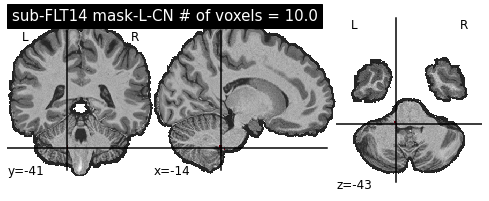

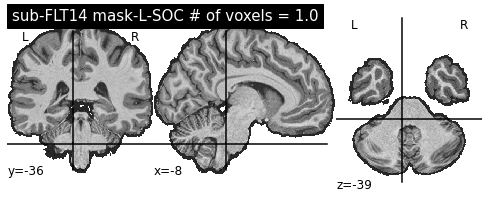

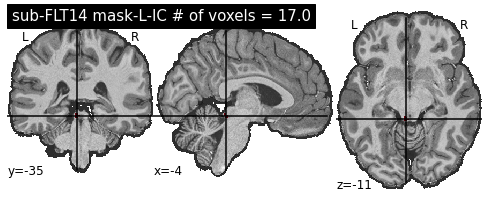

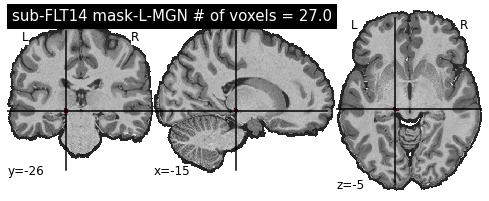

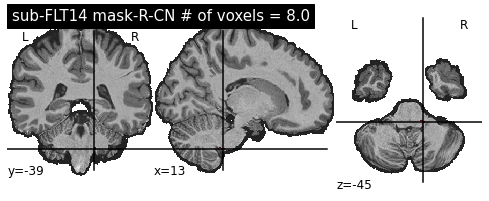

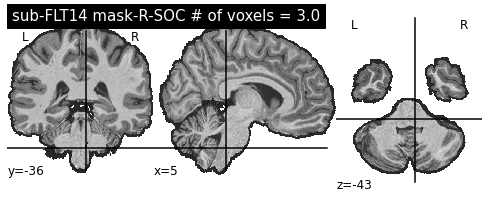

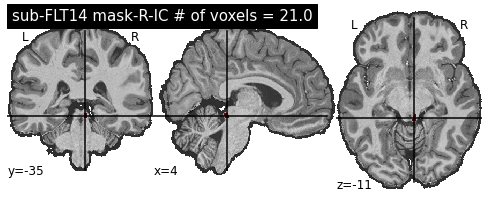

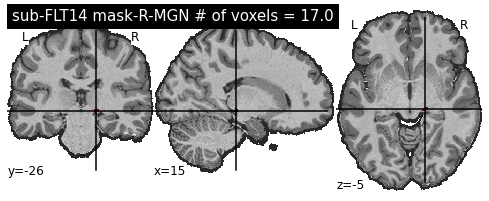

In [29]:
space_label = 'MNI152NLin2009cAsym'
roi_list = list(roi_dict.keys())

for sub_id in ['FLT14']: #sub_list:
    t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/',
                           'sub-{}/anat'.format(sub_id),
                           'sub-{}_space-{}_desc-preproc_T1w.nii.gz'.format(sub_id, space_label))
    
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-subcort-aud')#, 'masks-aparc' 'masks-subcort-aud'
    for mx, mask_descrip in enumerate(roi_list):
        # define the mask for the region of interest
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        mask_data = nib.load(mask_fpath).get_fdata()
        num_voxels = sum(sum(sum(mask_data)))

        display = plotting.plot_img(mask_fpath, bg_img=t1w_fpath, 
                                    title='sub-{} mask-{} # of voxels = {}'.format(sub_id, mask_descrip, num_voxels),
                                    threshold=0.5,
                                    vmin=0.5,
                                    cmap='Reds', 
                                    black_bg=False,
                                    #colorbar=True,
                                    )
        plotting.show()

## Extract atlas values

In [50]:
import os
from glob import glob
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from numpy import savetxt

In [51]:
atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                           'reference/', #tpl-MNI152NLin2009cAsym/',
                           'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz') 
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')

In [54]:
masker = NiftiLabelsMasker(labels_img=atlas_fpath, standardize=False,
                           memory='nilearn_cache', verbose=2)

In [57]:
fwhm = 1.5
sub_id = 'FLT08'
space_label = 'MNI152NLin2009cAsym'
nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                               'level-1_fwhm-%.02f'%fwhm, 
                               'sub-%s_space-%s'%(sub_id, space_label))    
stat_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*resid*.nii.gz'))
out_dir = os.path.join(nilearn_sub_dir, 'atlas_stat_vals')
os.makedirs(out_dir, exist_ok=True)

In [ ]:

for stat_fpath in stat_maps:
    stat_base = os.path.splitext(os.path.splitext(os.path.basename(stat_fpath))[0])[0]
    print(stat_base)
    
    atlas_values = masker.fit_transform(stat_fpath)[0]

    out_fpath = os.path.join(out_dir, stat_base+'_atlas-carpet'+'.tsv')
    savetxt(out_fpath, atlas_values, delimiter='/t')

sub-FLT08_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_trial1_run00_map-residuals
[NiftiLabelsMasker.fit_transform] loading data from /bgfs/bchandrasekaran/krs228/data/reference/tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-MNI152NLin2009cAsym/trial_models/run00/sub-FLT08_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_trial1_run00_map-residuals.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/bgfs/bchandrasekaran/krs228/data/reference/tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz',
  'low_pass': None,
  'mask_img': None,
  '

In [59]:
len(atlas_values)

116

In [60]:
from numpy import genfromtxt

In [61]:
x = genfromtxt(out_fpath)

In [62]:
x

array([ 6.96684479e-17,  1.02318001e-15, -6.07797488e-15, -5.35629255e-15,
       -3.87985914e-16, -1.10155505e-15, -8.36029873e-15, -9.09717456e-15,
        3.48460610e-15, -8.15042145e-15, -6.12165889e-15,  8.81536060e-16,
        1.51502461e-15, -7.24548007e-15, -8.78586917e-15,  1.87738356e-15,
        4.70963392e-16, -5.92645743e-15, -1.98965092e-15, -3.99215805e-15,
       -9.61420054e-16, -3.30446888e-15, -2.68346476e-15, -3.47883522e-15,
       -1.55243006e-15, -1.04452669e-15,  4.68459892e-15, -2.01974182e-15,
        4.32109239e-15, -2.08422595e-15,  1.34482806e-15, -2.94299654e-15,
       -1.82021879e-15,  1.48623120e-15,  2.42316560e-15, -4.43968969e-15,
        4.76327008e-15, -3.13672138e-15,  8.21585006e-16,  6.51406461e-15,
        6.48405891e-15,  1.73786245e-15,  3.29565425e-15,  4.95926750e-15,
        5.81944051e-15, -6.72587787e-15, -2.58129735e-15,  3.18135875e-15,
       -3.06521160e-16,  9.11238561e-16,  2.42605455e-15, -4.36809942e-15,
        9.00886956e-16,  